## How to run a Cosmological EoR Simulation

In this tutorial we will show how to run a simple cosmological EoR simulation with the pyC$^2$Ray code. This correspond to the main scirpt to run the code and it require some basic functions.

In [13]:
import pyc2ray as pc2r
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import astropy.units as u
import astropy.constants as cst

### Global parameters
As we saw in the the tutorial on the parameter of pyC$^2$Ray, most of the variables are defined in a parameter file, `parameters.yml`. However, we still need to define some global parameters for the cosmological simulation.

Moreover, we define the number of refined time-steps that we want to do in between redshift steps, `num_steps_between_slices`. This splits further the redshift-step and allows for a faster convergence of the ODE solution.

Lastly, we need to define the `redshifts` to simulate. We suggest, you pick the value corresponding to the snapshots of the inputs (i.e.: density field and source files).

In [14]:
# parameter file
paramfile = 'parameters.yml'

# refined time-steps
num_steps_between_slices = 20

# Define redshift list
redshifts = np.linspace(12, 10, 20)

Here we define a python class for our simulation as subclass of the basic C2Ray class, which is a standard version.

In [15]:
class C2Ray_tutorial(pc2r.c2ray_base.C2Ray):
    def __init__(self, paramfile):
        """Basis class for a C2Ray Simulation

        Parameters
        ----------
        paramfile : str
            Name of a YAML file containing parameters for the C2Ray simulation
        """
        super().__init__(paramfile)
        self.printlog('Running: "C2Ray tutorial for %d Mpc/h volume"' %self.boxsize)

    # ===========================================
    # HEREAFTER: USER DEFINED METHODS
    # ===========================================
    
    def read_sources(self, z, nsrc, dt):
        np.random.seed(918)
        
        # Read random sources (e.g.: *.npy, *.h5, etc.)
        pos_halo = np.random.uniform(low=0, high=sim.boxsize, size=(nsrc, 3))
        mhalo = np.random.uniform(1e8, 1e14, nsrc)*u.Msun

        # Define stellar-to-halo relation
        fstar = 0.1
        
        # Define escaping fraction
        fesc = 0.1
        
        # sum togheter the star mass for sources within the same voxel
        pos_star, mstar = pc2r.other_utils.bin_sources(srcpos_mpc=pos_halo, mstar_msun=mhalo*fstar*fesc, boxsize=sim.boxsize, meshsize=sim.N)
        
        """
        pos_star = np.array([sim.N//2, sim.N//2, sim.N//2])
        pos_star = pos_star[None,...]
        mstar = np.array([1e14])
        """        
        
        # this reference flux is necessary only for a numercial reason
        S_star_ref = 1e48
        
        # The normalize flux in CGS units
        dotN = (mstar*u.Msun/(cst.m_p*dt)).cgs.value
        
        # calculate some quantity thtat you want to print (e.g. total number of ionizing photons)
        self.tot_phots = np.sum(dotN * dt)

        return pos_star, dotN/S_star_ref
    
    def read_density(self, z):
        # Read the density field
        self.ndens = 1e-6 * np.ones((sim.N, sim.N, sim.N))
        return self.ndens

In [16]:
# init the C2Ray class for the tutorial
sim = C2Ray_tutorial(paramfile)

Number of GPUS 1
                 _________   ____            
    ____  __  __/ ____/__ \ / __ \____ ___  __
   / __ \/ / / / /    __/ // /_/ / __ `/ / / /
  / /_/ / /_/ / /___ / __// _, _/ /_/ / /_/ / 
 / .___/\__, /\____//____/_/ |_|\__,_/\__, /  
/_/    /____/                        /____/   

GPU Device ID 0: "NVIDIA RTX A1000 6GB Laptop GPU" with compute capability 8.6
Successfully allocated 536.871 Mb of device memory for grid of size N = 256, with source batch size 1
Welcome! Mesh size is N = 256.
Simulation Box size (comoving Mpc): 1.280e+02
Cosmology is on, scaling comoving quantities to the initial redshift, which is z0 = 12.000...
Cosmological parameters used:
h   = 0.6766, Tcmb0 = 2.725e+00
Om0 = 0.3097, Ob0   = 0.0490
Using power-law opacity with 10,000 table points between tau=10^(-20) and tau=10^(4)
Using Black-Body sources with effective temperature T = 5.0e+04 K and Radius  1.437e-11 rsun
Spectrum Frequency Range: 3.288e+15 to 1.316e+17 Hz
This is Energy:           1.

### Redshift Loop

We can now define the main cycle that loop over the different redshift. Within each redshift-step, a

- `set_timestep`: get the time length of the current redshift step (inherited from c2ray_base.py).
- `read_density`: read the IGM density field (custom function)
- `read_sources`: read the halos position and mass (custom function)
- `cosmo_evolve`:  (inherited from c2ray_base.py)
- `evolve3D`:  (inherited from c2ray_base.py)
- `cosmo_evolve_to_now`:  (inherited from c2ray_base.py)
- `write_output`: inherited from c2ray_base.py to save outputs and summary

Rank 0 copied source data to device.
Calling evolve3D...
dr [Mpc]: 3.847e-02
dt [years]: 2.261e+05
Running on 10 source(s), total normalized ionizing flux: 8.98e+08
Mean density (cgs): 9.994e-07, Mean ionized fraction: 1.200e-03
Convergence Criterion (Number of points):  3

Rank=0 is doing Raytracing... took 0.32s.
Doing Chemistry... took  1.6 s.
Number of non-converged points: 1115412 of 16777216 ( 6.648 % ), Relative change in ionfrac:  1.22e+02
Rank=0 is doing Raytracing... took 0.32s.
Doing Chemistry... took  1.5 s.
Number of non-converged points: 1114858 of 16777216 ( 6.645 % ), Relative change in ionfrac:  5.69e-01
Rank=0 is doing Raytracing... took 0.30s.
Doing Chemistry... took  1.5 s.
Number of non-converged points: 1085360 of 16777216 ( 6.469 % ), Relative change in ionfrac:  2.58e-01
Rank=0 is doing Raytracing... took 0.30s.
Doing Chemistry... took  1.3 s.
Number of non-converged points: 969272 of 16777216 ( 5.777 % ), Relative change in ionfrac:  8.25e-02
Rank=0 is doing Ra

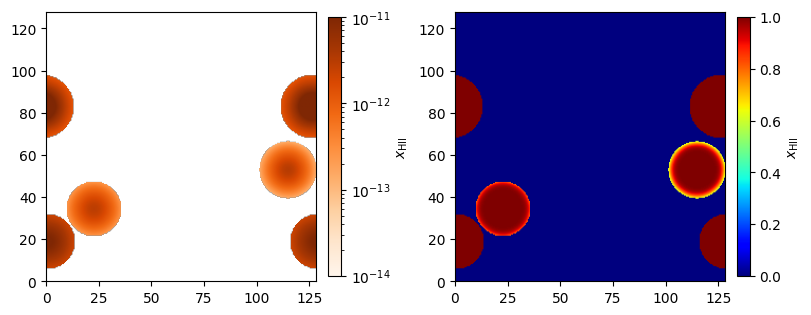

Rank 0 copied source data to device.
Calling evolve3D...
dr [Mpc]: 3.848e-02
dt [years]: 2.261e+05
Running on 10 source(s), total normalized ionizing flux: 8.98e+08
Mean density (cgs): 9.982e-07, Mean ionized fraction: 5.840e-02
Convergence Criterion (Number of points):  3

Rank=0 is doing Raytracing... took 0.32s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 378698 of 16777216 ( 2.257 % ), Relative change in ionfrac:  3.15e+01
Rank=0 is doing Raytracing... took 0.25s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 234562 of 16777216 ( 1.398 % ), Relative change in ionfrac:  1.38e-02
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 168666 of 16777216 ( 1.005 % ), Relative change in ionfrac:  4.52e-03
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.3 s.
Number of non-converged points: 141454 of 16777216 ( 0.843 % ), Relative change in ionfrac:  1.11e-03
Rank=0 is doing Raytr

<Figure size 640x480 with 0 Axes>

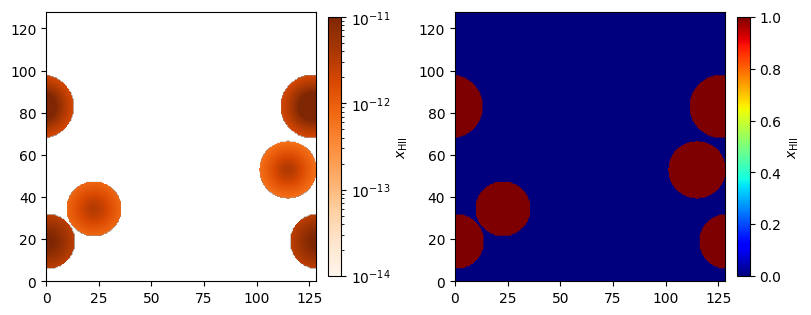

Rank 0 copied source data to device.
Calling evolve3D...
dr [Mpc]: 3.850e-02
dt [years]: 2.261e+05
Running on 10 source(s), total normalized ionizing flux: 8.98e+08
Mean density (cgs): 9.969e-07, Mean ionized fraction: 6.282e-02
Convergence Criterion (Number of points):  3

Rank=0 is doing Raytracing... took 0.32s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 202250 of 16777216 ( 1.206 % ), Relative change in ionfrac:  2.99e+01
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 141110 of 16777216 ( 0.841 % ), Relative change in ionfrac:  6.59e-03
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 106373 of 16777216 ( 0.634 % ), Relative change in ionfrac:  1.22e-03
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 61996 of 16777216 ( 0.370 % ), Relative change in ionfrac:  1.72e-04
Rank=0 is doing Raytra

<Figure size 640x480 with 0 Axes>

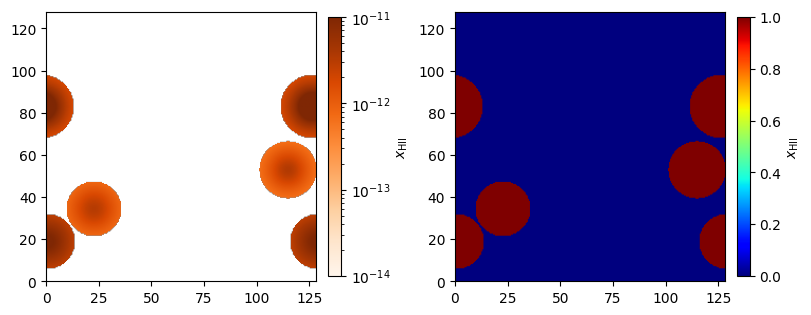

Rank 0 copied source data to device.
Calling evolve3D...
dr [Mpc]: 3.851e-02
dt [years]: 2.261e+05
Running on 10 source(s), total normalized ionizing flux: 8.98e+08
Mean density (cgs): 9.957e-07, Mean ionized fraction: 6.533e-02
Convergence Criterion (Number of points):  3

Rank=0 is doing Raytracing... took 0.34s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 156688 of 16777216 ( 0.934 % ), Relative change in ionfrac:  2.91e+01
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.4 s.
Number of non-converged points: 97177 of 16777216 ( 0.579 % ), Relative change in ionfrac:  2.20e-03
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.3 s.
Number of non-converged points: 45558 of 16777216 ( 0.272 % ), Relative change in ionfrac:  2.53e-04
Rank=0 is doing Raytracing... took 0.26s.
Doing Chemistry... took  1.3 s.
Number of non-converged points: 0 of 16777216 ( 0.000 % ), Relative change in ionfrac:  2.31e-05
Multiple source convergence 

<Figure size 640x480 with 0 Axes>

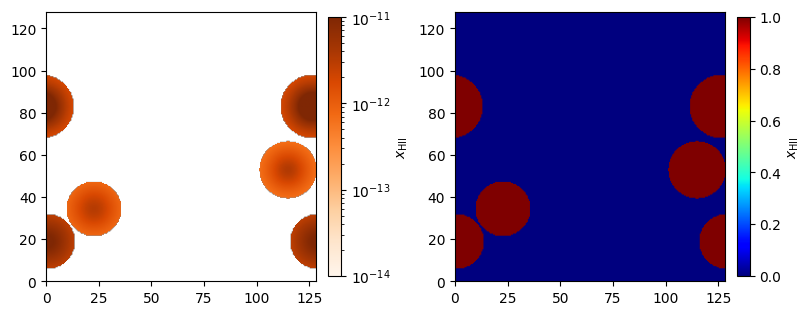

Rank 0 copied source data to device.
Calling evolve3D...
dr [Mpc]: 3.853e-02
dt [years]: 2.261e+05
Running on 10 source(s), total normalized ionizing flux: 8.98e+08
Mean density (cgs): 9.945e-07, Mean ionized fraction: 6.669e-02
Convergence Criterion (Number of points):  3

Rank=0 is doing Raytracing... took 0.32s.
Doing Chemistry... 

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [17]:
for k in range(redshifts.size-1):
    # redshift at the begin and end of the step
    zi = redshifts[k]
    zf = redshifts[k+1]
    
    # Write a nice header in pyc2ray log file
    sim.printlog("\n=========== Doing redshift %.3f to %.3f ===========\n" %(zi, zf), sim.logfile)

    # Compute timestep of current redshift slice
    dt = sim.set_timestep(zi, zf, num_steps_between_slices)
    
    # Read density files
    sim.read_density(z=zi)

    # Read source files
    srcpos, normflux = sim.read_sources(nsrc=10, z=zi, dt=dt)
    
    # Set redshift to current slice redshift
    sim.zred = zi
    
    # Loop over timesteps
    for t in range(num_steps_between_slices):
        
        # Evolve Cosmology: increment redshift and scale physical quantities (density, proper cell size, etc.)
        sim.cosmo_evolve(dt)

        # Evolve the simulation: compute column density -> get photoionization rates -> do chemistry (repeat until convergence)
        sim.evolve3D(dt, normflux, srcpos)

        # You can eventually plot on the fly to have a look at the simulation
        fig, axs = plt.subplots(figsize=(8, 8), nrows=1, ncols=2, constrained_layout=True)

        # plot photoionization rate and hydrogen ionized fraction
        #im = axs[0].imshow(np.sum(sim.phi_ion, axis=0), norm=LogNorm(vmin=1e-14, vmax=1e-11), cmap='Oranges', extent=[0, sim.boxsize, 0, sim.boxsize])
        im = axs[0].imshow(sim.phi_ion[0], norm=LogNorm(vmin=1e-14, vmax=1e-11), cmap='Oranges', extent=[0, sim.boxsize, 0, sim.boxsize])
        plt.colorbar(im, ax=axs[0], label=r'$x_\mathrm{HII}$', pad=0.02, fraction=0.048)

        #im = axs[1].imshow(np.sum(sim.xh, axis=0), vmin=0, vmax=1, cmap='jet', extent=[0, sim.boxsize, 0, sim.boxsize])
        im = axs[1].imshow(sim.xh[0], vmin=0, vmax=1, cmap='jet', extent=[0, sim.boxsize, 0, sim.boxsize])
        plt.colorbar(im, ax=axs[1], label=r'$x_\mathrm{HII}$', pad=0.02, fraction=0.048)
        plt.show(), plt.clf()

    # Evolve cosmology over final half time step to reach the correct time for next slice
    sim.cosmo_evolve_to_now()

    # Write outputs (HII field and photoioniation rate) of the redshift step after updating the neutral fraction
    sim.write_output(z=zi, ext='.npy')
    
print('Simulation ended.')